# Plots to Assess Regression Models

In this notebook we will discuss some diagnostic plots for regression models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# Generating synthetic data
rng = np.random.default_rng(216)
X = rng.normal(scale= 2, loc = 2, size=(1000,3))
X[:,2] = rng.binomial(n=1, p=0.5, size = (1000,))
y = 3 + X[:,0] + 2*X[:,1] + X[:,0]*X[:,1]/4 + X[:,1]**2/4 + 5*X[:,2] + rng.normal(scale= 0.5, loc = 0, size=1000)

This synthetic data is of the form

$$
y = 3 + x_0 + 2x_1 + \frac{1}{4}x_0x_1 + \frac{1}{4}x_1^2 + 5x_2 + \epsilon
$$

where $x_0, x_1 \sim \mathcal{N}(\mu = 2, \sigma^2 = 4)$, $x_2$ is either $0$ or $1$ with probability $0.5$, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma^2 = 0.25)$.

NOTE:  For ease of coding and illustrating the ideas, I will not do any data splits in this notebook.  In practice you will probably want to make these plots for cross-validation holdouts as well to assess model generalization performance.

Now pretend we don't know the data generating process and we would like to make some graphs to assess the quality of different models.

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
model = LinearRegression()

model.fit(X[:, [0,1]], y)

preds = model.predict(X[:, [0,1]])

residuals = y - preds

One way to assess the quality of this model is by making **residual vs. feature** plots.  Notice that we have made such plots both for features included in the model and those that we left out but are considering putting in later.

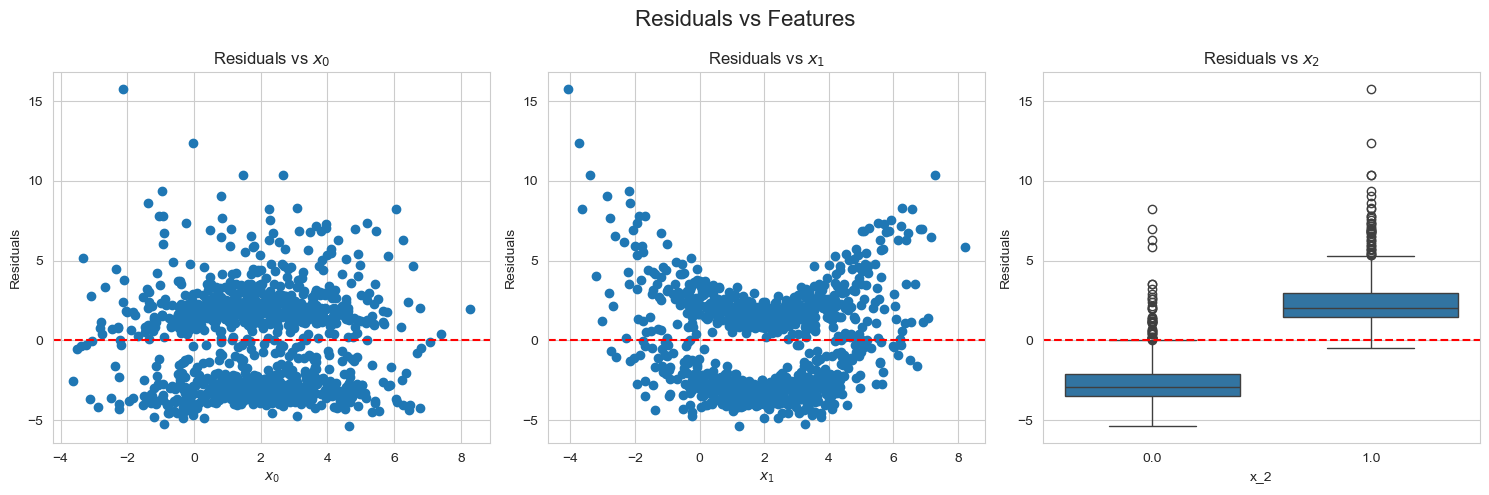

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Residuals vs x_0
axs[0].scatter(X[:,0], residuals)
axs[0].axhline(0, color='r', linestyle='--')
axs[0].set_xlabel("$x_0$")
axs[0].set_ylabel("Residuals")
axs[0].set_title("Residuals vs $x_0$")

# Residuals vs x_1
axs[1].scatter(X[:,1], residuals)
axs[1].axhline(0, color='r', linestyle='--')
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("Residuals")
axs[1].set_title("Residuals vs $x_1$")

# Residuals vs x_2
sns.boxplot(x=X[:,2], y=residuals, ax=axs[2])
axs[2].axhline(0, color='r', linestyle='--')
axs[2].set_xlabel("x_2")
axs[2].set_ylabel("Residuals")
axs[2].set_title("Residuals vs $x_2$")

plt.suptitle("Residuals vs Features", fontsize=16)
plt.tight_layout()
plt.show()

We can immediately see that the target does depend on $x_2$.  We also see that we may be missing some quadratic dependence on $x_1$ and $x_2$.

* You are hoping to see "pure noise" centered at $y=0$.  Basically a blob of points.
* If you see more than one blob you are probably missing a categorical feature which may or may not have already been collected!  You might go back to your data collection step and try to identify a categorical feature which is missing (e.g. record which browser someone is using to access your website).
* If you see clear patterns in the residuals then you know that there is "signal being left on the table".  You should either engineer more features to capture those patterns or use a more flexible regressor.

Residual vs. Feature plots become unwieldly when you have tons of features.  It is also handy to look at **residual vs. predicted value** plots.  In this case I will also color according to the level of $x_2$.

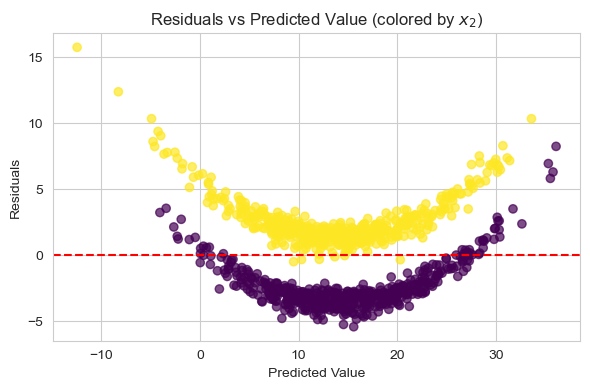

In [6]:
plt.figure(figsize=(6, 4))

# Scatter plot: residuals vs predicted, colored by x_2
scatter = plt.scatter(
    preds, residuals, 
    c=X[:,2], cmap='viridis', alpha=0.7
)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Value (colored by $x_2$)")

plt.tight_layout()
plt.show()

This also clearly shows the need to include $x_2$ in the model, as well as the potential for a quadratic dependence.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Columns to transform
poly_features = [0, 1]  # X[:,0] and X[:,1]
pass_through = [2]      # X[:,2]

# ColumnTransformer: polynomial on first 2 features, passthrough the last
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), poly_features),
        ('passthrough', 'passthrough', pass_through)
    ]
)

# Full pipeline: preprocessing + linear model
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('linreg', LinearRegression())
])

# Fit the pipeline
pipeline.fit(X, y)

# Make predictions
pipeline_preds = pipeline.predict(X)

# Get residuals
pipeline_residuals = y - pipeline_preds

Let's make the same graphs and see how our model is doing now.

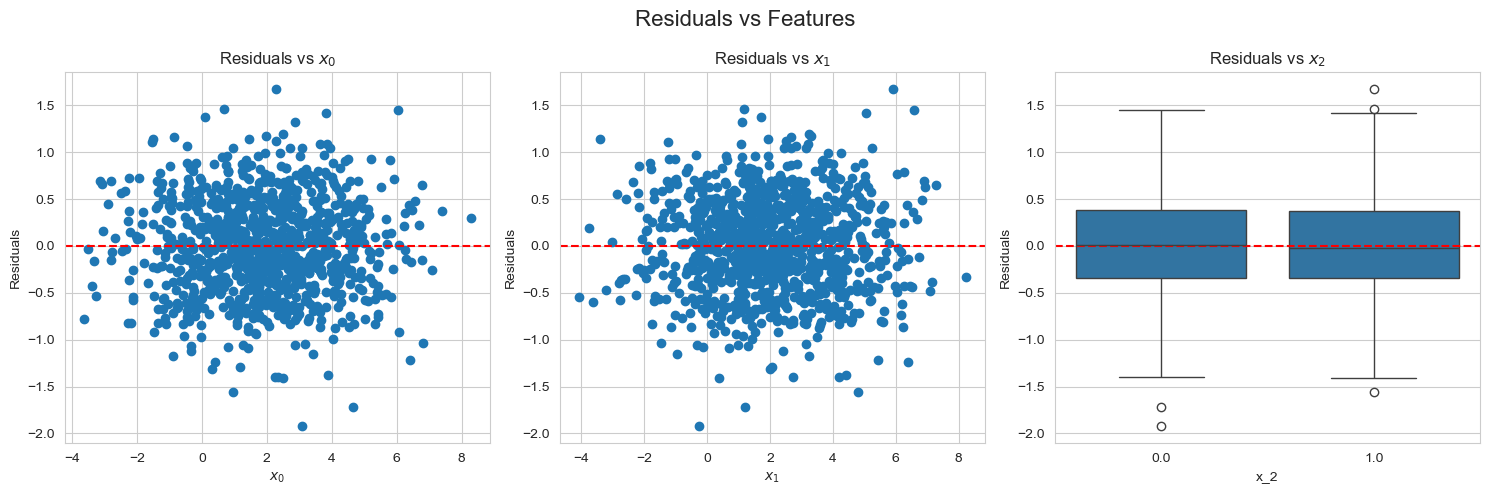

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Residuals vs x_0
axs[0].scatter(X[:,0], pipeline_residuals)
axs[0].axhline(0, color='r', linestyle='--')
axs[0].set_xlabel("$x_0$")
axs[0].set_ylabel("Residuals")
axs[0].set_title("Residuals vs $x_0$")

# Residuals vs x_1
axs[1].scatter(X[:,1], pipeline_residuals)
axs[1].axhline(0, color='r', linestyle='--')
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("Residuals")
axs[1].set_title("Residuals vs $x_1$")

# Residuals vs x_2
sns.boxplot(x=X[:,2], y=pipeline_residuals, ax=axs[2])
axs[2].axhline(0, color='r', linestyle='--')
axs[2].set_xlabel("x_2")
axs[2].set_ylabel("Residuals")
axs[2].set_title("Residuals vs $x_2$")

plt.suptitle("Residuals vs Features", fontsize=16)
plt.tight_layout()
plt.show()

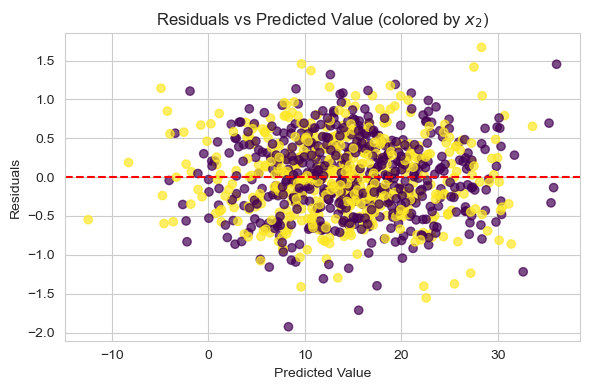

In [9]:
plt.figure(figsize=(6, 4))

# Scatter plot: residuals vs predicted, colored by x_2
scatter = plt.scatter(
    preds, pipeline_residuals, 
    c=X[:,2], cmap='viridis', alpha=0.7
)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Value (colored by $x_2$)")

plt.tight_layout()
plt.show()

This is what we like to see!  There is (apparently) no remaining "signal" to extract from the data.

We can check whether the residuals do seem to follow a normal distribution with a QQ-plot:

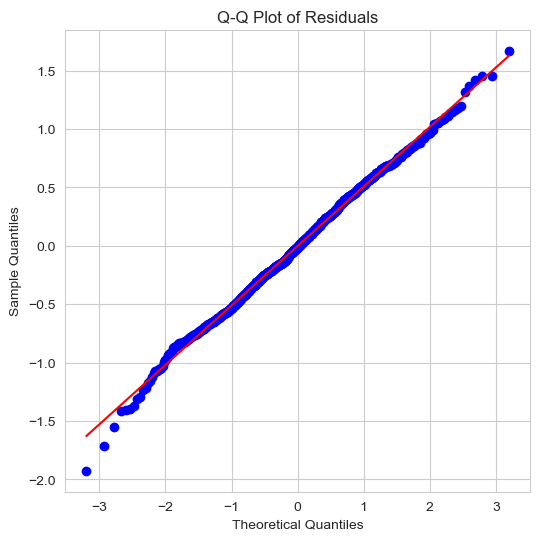

In [10]:
import scipy.stats as stats

# Compute residuals if you haven't already
# residuals = y - y_pred

plt.figure(figsize=(6,6))

# Q-Q plot
stats.probplot(pipeline_residuals, dist="norm", plot=plt)

plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

See this stackoverflow answer for a thorough guide on interpretting QQ plots:

https://stats.stackexchange.com/a/101290/97124

In [11]:
# Access feature names
poly_step = pipeline.named_steps['preprocess'].named_transformers_['poly']
feature_names = list(poly_step.get_feature_names_out(['x0','x1'])) + ['x2']

# Coefficients
coeffs = pipeline.named_steps['linreg'].coef_

# Print feature names and coefficients
for name, coef in zip(feature_names, coeffs):
    print(f"{name:10s}: {coef:.3f}")

x0        : 1.026
x1        : 2.001
x0^2      : -0.001
x0 x1     : 0.245
x1^2      : 0.249
x2        : 4.999


These kinds of plots can also be used to assess heteroskedasticity of the error term.  In other words, whether or not the error term follows the same distribution independent of the value of the inputs.  Let's redefine our original data to include heteroskedastic error.

In [12]:
# Generating synthetic data
rng = np.random.default_rng(216)
X = rng.normal(scale= 2, loc = 2, size=(1000,3))
X[:,2] = rng.binomial(n=1, p=0.5, size = (1000,))

variance = 0.01 + np.abs(np.sin(X[:,0]))
std_dev = np.sqrt(variance)

# Noise term
epsilon = std_dev * rng.normal(size=1000)

# Response
y = 3 + X[:,0] + 2*X[:,1] + X[:,0]*X[:,1]/4 + X[:,1]**2/4 + 5*X[:,2] + epsilon

In [13]:
# Fit the pipeline
pipeline.fit(X, y)

# Make predictions
pipeline_preds = pipeline.predict(X)

# Get residuals
pipeline_residuals = y - pipeline_preds

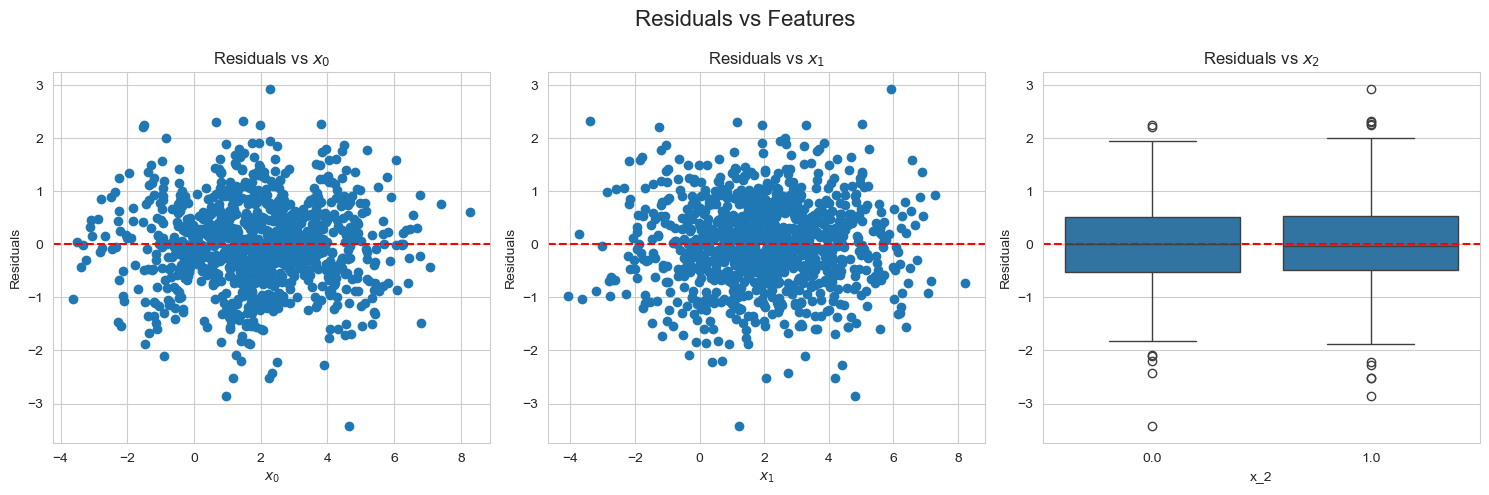

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Residuals vs x_0
axs[0].scatter(X[:,0], pipeline_residuals)
axs[0].axhline(0, color='r', linestyle='--')
axs[0].set_xlabel("$x_0$")
axs[0].set_ylabel("Residuals")
axs[0].set_title("Residuals vs $x_0$")

# Residuals vs x_1
axs[1].scatter(X[:,1], pipeline_residuals)
axs[1].axhline(0, color='r', linestyle='--')
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("Residuals")
axs[1].set_title("Residuals vs $x_1$")

# Residuals vs x_2
sns.boxplot(x=X[:,2], y=pipeline_residuals, ax=axs[2])
axs[2].axhline(0, color='r', linestyle='--')
axs[2].set_xlabel("x_2")
axs[2].set_ylabel("Residuals")
axs[2].set_title("Residuals vs $x_2$")

plt.suptitle("Residuals vs Features", fontsize=16)
plt.tight_layout()
plt.show()

We can see that the variance is not constant, since it is smaller when $x_0$ is near multiples of $\pi$.

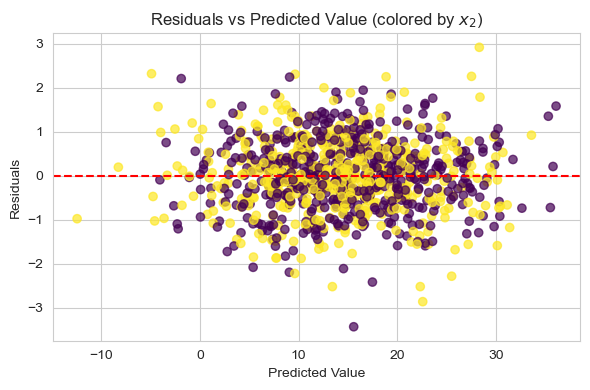

In [15]:
plt.figure(figsize=(6, 4))

# Scatter plot: residuals vs predicted, colored by x_2
scatter = plt.scatter(
    preds, pipeline_residuals, 
    c=X[:,2], cmap='viridis', alpha=0.7
)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Value (colored by $x_2$)")

plt.tight_layout()
plt.show()

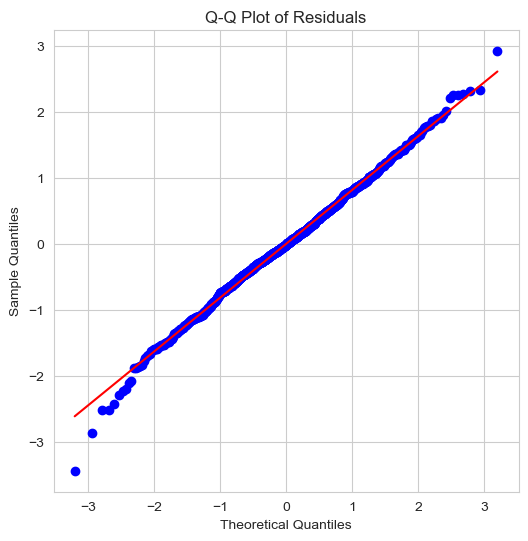

In [16]:
import scipy.stats as stats

# Compute residuals if you haven't already
# residuals = y - y_pred

plt.figure(figsize=(6,6))

# Q-Q plot
stats.probplot(pipeline_residuals, dist="norm", plot=plt)

plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

We discussed the following kinds of plots in this notebook:

1. **Residuals vs Predicted Values**  
   - Detect nonlinearity, heteroskedasticity, or bias.  
   - Works for any regression model.

2. **Residual vs Feature Plots**  
   - Useful to detect patterns missed by the model.  
   - Can be applied to one or more features.

3. **Q-Q Plot of Residuals**  
   - Compare residuals to a theoretical distribution (e.g., normal).  
   - Highlights non-normality or outliers.

Here are some more types of plots you might consider:

## For any regression model
1. **Predicted vs Actual / Observed Values**  
   - Simple check for overall model fit.

2. **Histogram of Residuals**  
   - Check for skewness, heavy tails, or unusual spread.

3. **Scale-Location Plot (Spread of Residuals)**  
   - Residuals vs fitted values after sqrt(abs(residuals)) transformation.  
   - Detect heteroskedasticity.

## For linear models specifically
1. **Partial Regression / Added-Variable Plots**  
   - Show the effect of a predictor after adjusting for other predictors.

2. **Component + Residual (CERES) Plots**  
   - Examine linearity between each predictor and response.

3. **Residuals vs Leverage**  
   - Combines leverage and standardized residuals to detect influential points.

4. **Studentized Residuals Plot**  
   - Highlights outliers more formally than raw residuals.
